In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 2.6MB/s 
     |████████████████████████████████| 2.9MB 17.5MB/s 
     |████████████████████████████████| 890kB 37.2MB/s 
     |████████████████████████████████| 1.1MB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e96eb5dd8f3e52407a0fee43ad9c7dcdcfd013eb90e7971fe1b4eb5177daf2ba
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!nvidia-smi

Fri Oct 30 15:39:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    38W / 300W |   3269MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Demonstration of a basic Seq2Seq chatbot trained by language modelling

### References: 
1. https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
2. https://huggingface.co/docs/tokenizers/python/latest/
3. https://arxiv.org/pdf/1506.05869.pdf

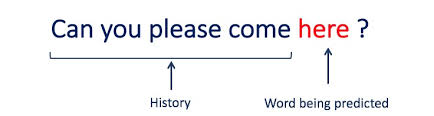

# Step 1: Collecting the data

We are going to use the Cornell movie dialogs corpus.
This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts:



- 220,579 conversational exchanges between 10,292 pairs of movie characters

- involves 9,035 characters from 617 movies

- in total 304,713 utterances

- movie metadata included:

    - genres

    - release year

    - IMDB rating

    - number of IMDB votes

    - IMDB rating

- character metadata included:

    - gender (for 3,774 characters)

    - position on movie credits (3,321 characters)


In [ ]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip cornell_movie_dialogs_corpus.zip
!mkdir data
!mv ./cornell\ movie-dialogs\ corpus ./data/

--2020-11-12 14:03:32--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 52.201.128.190
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|52.201.128.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  4.69MB/s    in 2.0s    

2020-11-12 14:03:35 (4.69 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

# Step 2: Preprocessing the data

In [ ]:
# Lets see how the data looks like. Notice each user turn starts with L***. 
# Each utterance contains: "lineID", "characterID", "movieID", "character", "text"
# Delimiter: +++$+++
# We are going to create pairs from such consecutive utterances

corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("data", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [ ]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines

# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]

# Load lines and process conversations
print("\nProcessing corpus...")

# We create a nested dictionary "lines" which consist of lineid as key, and
# character name, id, lineid, movieid and text as values

lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)


Processing corpus...


In [ ]:
lines

{'L1045': {'character': 'BIANCA',
  'characterID': 'u0',
  'lineID': 'L1045',
  'movieID': 'm0',
  'text': 'They do not!\n'},
 'L1044': {'character': 'CAMERON',
  'characterID': 'u2',
  'lineID': 'L1044',
  'movieID': 'm0',
  'text': 'They do to!\n'},
 'L985': {'character': 'BIANCA',
  'characterID': 'u0',
  'lineID': 'L985',
  'movieID': 'm0',
  'text': 'I hope so.\n'},
 'L984': {'character': 'CAMERON',
  'characterID': 'u2',
  'lineID': 'L984',
  'movieID': 'm0',
  'text': 'She okay?\n'},
 'L925': {'character': 'BIANCA',
  'characterID': 'u0',
  'lineID': 'L925',
  'movieID': 'm0',
  'text': "Let's go.\n"},
 'L924': {'character': 'CAMERON',
  'characterID': 'u2',
  'lineID': 'L924',
  'movieID': 'm0',
  'text': 'Wow\n'},
 'L872': {'character': 'BIANCA',
  'characterID': 'u0',
  'lineID': 'L872',
  'movieID': 'm0',
  'text': "Okay -- you're gonna need to learn how to lie.\n"},
 'L871': {'character': 'CAMERON',
  'characterID': 'u2',
  'lineID': 'L871',
  'movieID': 'm0',
  'text': 'No

In [ ]:
# The movie_conversations.txt contains metadata pertaining to which lines constitute a valid conversation
# The fields present are : ["character1ID", "character2ID", "movieID", "utteranceIDs"]
# It specifies Character1 & 2 conversed in movie m, and their utterances are [L..,L..,...]
# "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']\n",
# "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']\n"

# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations

print("\nLoading conversations...")
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)



Loading conversations...


In [ ]:
conversations

[{'character1ID': 'u0',
  'character2ID': 'u2',
  'lines': [{'character': 'BIANCA',
    'characterID': 'u0',
    'lineID': 'L194',
    'movieID': 'm0',
    'text': 'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'},
   {'character': 'CAMERON',
    'characterID': 'u2',
    'lineID': 'L195',
    'movieID': 'm0',
    'text': "Well, I thought we'd start with pronunciation, if that's okay with you.\n"},
   {'character': 'BIANCA',
    'characterID': 'u0',
    'lineID': 'L196',
    'movieID': 'm0',
    'text': 'Not the hacking and gagging and spitting part.  Please.\n'},
   {'character': 'CAMERON',
    'characterID': 'u2',
    'lineID': 'L197',
    'movieID': 'm0',
    'text': "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"}],
  'movieID': 'm0',
  'utteranceIDs': "['L194', 'L195', 'L196', 'L197']\n"},
 {'character1ID': 'u0',
  'character2ID': 'u2',
  'lines': [{'character': 'B

In [ ]:
# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
# print("\nSample lines from file:")
# printLines(datafile)


Writing newly formatted file...


In [ ]:
extractSentencePairs(conversations)[:4]

[['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
  "Well, I thought we'd start with pronunciation, if that's okay with you."],
 ["Well, I thought we'd start with pronunciation, if that's okay with you.",
  'Not the hacking and gagging and spitting part.  Please.'],
 ['Not the hacking and gagging and spitting part.  Please.',
  "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"],
 ["You're asking me out.  That's so cute. What's your name again?",
  'Forget it.']]

In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        # Mapping word to numeric id
        self.word2index = {}
        # Mapping numeric id to word
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [ ]:
MAX_LENGTH = 15  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:5]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 111344 sentence pairs
Counting words...
Counted words: 26856

pairs:
['no no it s my fault we didn t have a proper introduction', 'cameron .']
['gosh if only we could find kat a boyfriend . . .', 'let me see what i can do .']
['c esc ma tete . this is my head', 'right . see ? you re ready for the quiz .']
['that s because it s such a nice one .', 'forget french .']
['how is our little find the wench a date plan progressing ?', 'well there s someone i think might be']


In [ ]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs

# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 13150 / 26853 = 0.4897
Trimmed from 111344 pairs to 95878, 0.8611 of total


In [ ]:
pairs[-1]

['which one ?', 'well that one . the one who keeps looking at me .']

In [ ]:
import pickle
pickle.dump(pairs, open('./pairs.pickle', 'wb'))

In [ ]:
# !cp ./pairs.pickle ./drive/My\ Drive/Conversational\ AI\ SIG\ Fall\ 2020/Session\ 3:\ Nov\ 13\ 2020/

# Step 3: Create training data

### Byte Pair Encoding

In [ ]:
1. Easier & faster
2. tak ing do ing | tak e do
3. Do not have to worry about out of vocab !!

In [ ]:
from tokenizers import ByteLevelBPETokenizer


In [ ]:
# BPE is specific to a corpus. Hence, we need to create a corpus first.
# Join all the pairs to create a corpus

corpus = ""
for i in pairs:
    corpus += " ".join(i)

print(corpus[:300])
f = open('./corpus.txt', 'w')
f.write(corpus) 
f.close()

no no it s my fault we didn t have a proper introduction cameron .gosh if only we could find kat a boyfriend . . . let me see what i can do .that s because it s such a nice one . forget french .there . where ?you have my word . as a gentleman you re sweet .hi . looks like things worked out tonight h


In [ ]:
# Initialize the BPE tokenizer by huggingface
tokenizer = ByteLevelBPETokenizer()

# Train the BPE tokenizer on the previously created corpus.
# We set min_frequency to split = 2 and vocab_size = 20,000
# We also add special start and end tokens <s>, </s>, padding token <pad> .etc to the tokenizer
# This is similar to RoBERTa & GPT 2 tokenizer

tokenizer.train(files=['./corpus.txt'], vocab_size=9000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])
tokenizer.save_model(".", "cornell_s2s")

['./cornell_s2s-vocab.json', './cornell_s2s-merges.txt']

In [ ]:
query-> <s>hello how are you?</s>
response -> <s>I am good</s><pad>

[1,2,3,4]
[7,8,9]

[4, 8]
[9,10,11]

In [ ]:
import json
crp = json.load(open('./cornell_s2s-vocab.json','r'))
len(crp)

9000

In [ ]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# After the tokenizer is trained, we initialize the tokenizer with the created
# vocab and merges file. we specify the processing functionalities to be similar 
# to BERT. i.e we can leverage attention_masks, type_ids, ids .etc. functionalities
# with the initialized tokenizer.

# We also spicify the tokenizer to automatically pad each sentence to the max_length
# of the corpus, and enable truncation to length of 50 tokens.

# All these functionalities with just a few lines of code !!

tokenizer = ByteLevelBPETokenizer('./cornell_s2s-vocab.json', 
                                  './cornell_s2s-merges.txt')
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=128)
tokenizer.enable_padding(pad_id=1, pad_token='<pad>')

print(tokenizer.encode("hello world"))

Encoding(num_tokens=4, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


In [ ]:
# Let's test out some functionalities of the tokenizer
print(tokenizer.encode("hello world").ids)
print(tokenizer.decode(tokenizer.encode("hello world").ids))

[0, 986, 1393, 2]
<s>hello world</s>


### Create Train, Valid & Test data

In [ ]:

# Split pairs into 2 lists: query(X) & response(Y)
X, Y = [], []
for pair in pairs:
    X.append(pair[0])
    Y.append(pair[1])

print(len(X), len(Y))

95878 95878


In [ ]:
# We can tokenize, encode & pad all the queries & responses
# by just invoking the encode_batch function !!

X_tokenized = [i.ids for i in tokenizer.encode_batch(X)]
Y_tokenized = [i.ids for i in tokenizer.encode_batch(Y)]
print(len(X_tokenized), len(Y_tokenized))

95878 95878


In [ ]:
#Lets look at one tokenized sentence
print(X_tokenized[0])
print(tokenizer.decode(X_tokenized[0]),"\n",X[0])

[0, 281, 296, 292, 265, 368, 2086, 319, 494, 262, 355, 270, 2659, 6081, 1201, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s>no no it s my fault we didn t have a proper introduction</s><pad><pad><pad><pad><pad><pad><pad><pad><pad> 
 no no it s my fault we didn t have a proper introduction


In [ ]:
from sklearn.model_selection import train_test_split

# Create 80:10:10 training, testing and validation splits

X_train, X_test, Y_train, Y_test = train_test_split(X_tokenized, Y_tokenized, 
                                                    test_size=0.2, random_state=42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test, Y_test, 
                                                    test_size=0.5, random_state=42)

print(len(X_train), len(Y_train), len(X_valid), len(Y_valid), len(X_test), len(Y_test))

76702 76702 9588 9588 9588 9588


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Below we define a function to create train, test & valid dataloaders in Pytorch

batch_size = 128

def get_dataloader(x, y):
    x = torch.tensor(x).long()  #batch , max_len
    y = torch.tensor(y).long()  #batch , max_len
    x_lens = torch.sum(torch.tensor(x) != 1, 1) #batch
    y_lens = torch.sum(torch.tensor(y) != 1, 1) #batch

    data = TensorDataset(x, x_lens, y, y_lens)
    sampler = RandomSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    return dataloader

train_datalaoder = get_dataloader(X_train, Y_train)
valid_datalaoder = get_dataloader(X_valid, Y_valid)
test_datalaoder = get_dataloader(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Sanity check that the tensors returned by the dataloader are correct

for batch in train_datalaoder:
    x, x_lens, y, y_lens = batch
    print(x.shape, x_lens.shape, y.shape, y_lens.shape)
    break


torch.Size([128, 25]) torch.Size([128]) torch.Size([128, 25]) torch.Size([128])


## The picture so far:


1.   We preprocessed our data
2.   Defined a Byte Pair Encoding tokenizer
3.   Tokenized and padded our query:response pairs
4.   Generated train, test & valid splits
5.   Defined Pytorch dataloaders which will generate mini batches of data for training



# Step 4: Model training - Seq2Seq Recurrent Neural Network (RNN)
Aka - Encoder:Decoder Architecture

### Gated Recurrent Unit (GRU)


1.   GRUs are improved version of standard recurrent neural network. 
2.   Update gate (z): How much of the past information needs to be passed to the future 
3.   Reset gate (r): How much of the past inforamtion to forget
4.   Current memory (h): Contains the current hidden state of the network after observing the current input x.
5.   Can be trained faster than LSTM, and performs equally good 



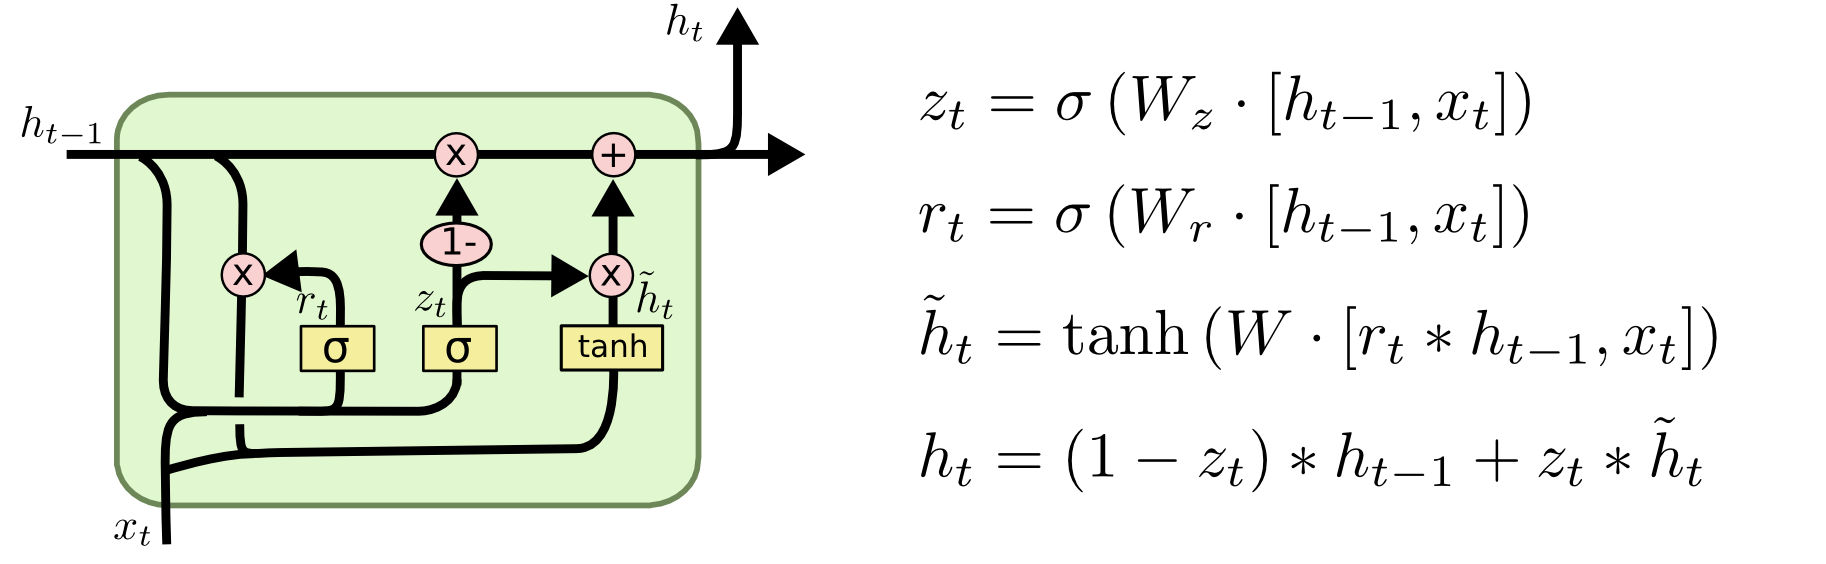

# Pytorch RNN packed padded sequence
Ref: https://www.youtube.com/watch?v=CNuI8OWsppg&t=14138s&ab_channel=freeCodeCamp.org

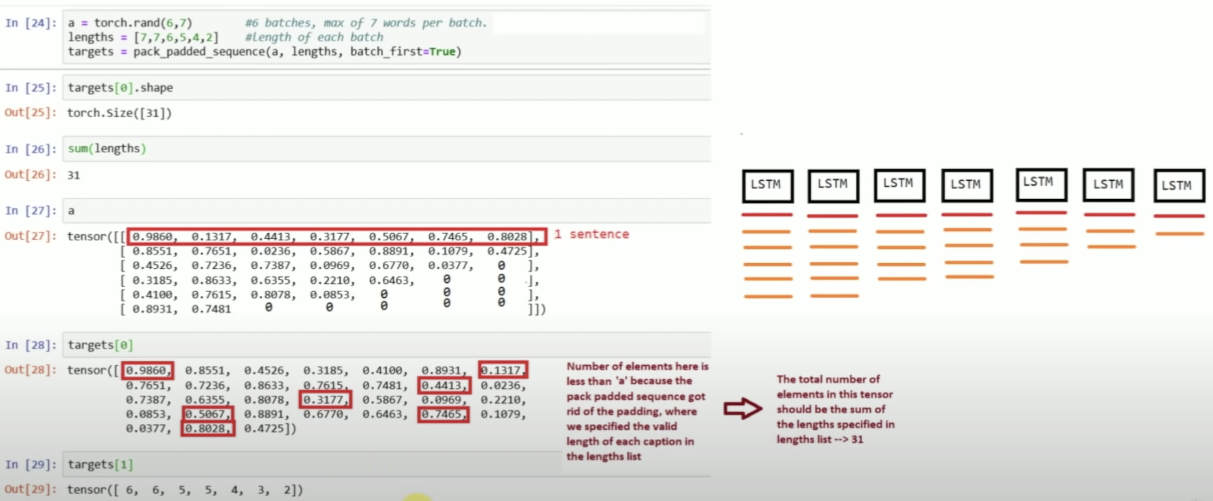

In [ ]:
hello: 1245
hi: 38
[0, 1245, 234, 233, 2, 1,1,1]

### Bi-directional, multi-layerd GRU encoder

In [ ]:
class classname(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.layer1 = nn.Conv2d()
        self.layer2 = nn.Linear(input, output)
    
    def forward(self):
        pass

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, device, n_layers=1, dropout=0):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        self.directions = 2
        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
        self.device = device

    def forward(self, input_seq, input_lengths):
        # Convert word indexes to embeddings
        # input_seq: seq_len, batch
        # input_lengths: batch
        
        batch = input_seq.shape[1]
        embedded = self.embedding(input_seq)
  
        # embedded: seq_len, batch, hidden_size

        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, 
                                                   batch_first=False,
                                                   enforce_sorted=False)

        # Forward pass through GRU
        hidden = torch.randn(self.n_layers*self.directions, batch, self.hidden_size).to(self.device)

        outputs, hidden = self.gru(packed, hidden)      

        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)

        # Sum bidirectional GRU outputs & hidden
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        hidden = torch.sum(hidden.view(-1, 2, batch, self.hidden_size), dim=1)

        # Return output and final hidden state
        # outputs: (seq_len, batch, hidden_size)
        # hidden: (n_layers, batch, hidden_size)

        return outputs, hidden

# Important Concepts in Encoder:
1. Embedding: A mapping which maps a token index to a high dimensional representation. The representations are learned during training, and it captures relationships between tokens in a sentence.
2. Pack Padded Sequence: This helps reduce the computation by removing input sequence padding, and packing it as a continuous tensor. This helps leverage the dynamic computation graph capabilities of Pytorch
3. The encoder is 
    *   Bidirectional: Encodes a sequence both from left to right & from right to left
    *   Multi-layered: Stacks of bidirectional encoder layers.










### Luong concatenated Attention

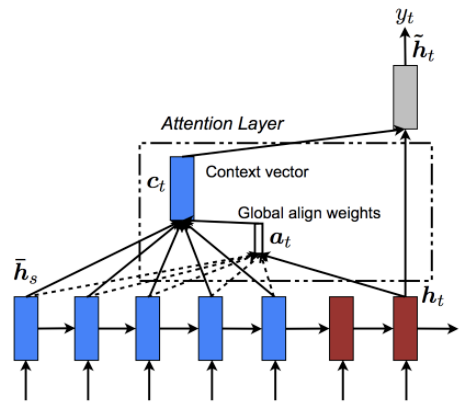

In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.randn(hidden_size))

    def concat_score(self, hidden, encoder_output):
        # hidden: 1, batch, hidden_size
        # encoder_output: seq_len, batch, hidden_size

        repeat_decoder_hidden = hidden.repeat(encoder_output.size(0), 1, 1) #seq_len, batch, hidden_size
        # print('repeat_decoder_hidden', repeat_decoder_hidden)
        concatenate_hidden = torch.cat([repeat_decoder_hidden, encoder_output], -1) #seq_len, batch, hidden_size*2
        energy = self.attn(concatenate_hidden).tanh() #seq_len, batch, hidden_size
        # print('energy', energy)
        return torch.sum(self.v * energy, dim=-1) #seq_len, batch

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies)
        attn_energies = self.concat_score(hidden, encoder_outputs) #seq_len, batch
        # print('attn_energies', attn_energies)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.permute(1,0) #batch, seq_len

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=-1).unsqueeze(1)  #batch, 1, seq_len

### Uni-directional, multi-layered GRU decoder with attention mechanism

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super().__init__()
        # Define layers
        self.embedding = embedding
        self.attn = Attn(hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat_layer = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # input_step: 1, batch_size
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)

        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # rnn_output: (1, batch, hidden_size)
        # hidden: (num_layers * num_directions, batch, hidden_size)

        attn_weights = self.attn(rnn_output, encoder_outputs) # batch, 1, seq_len
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.permute(1, 0, 2)) # batch, 1, hidden_size

        rnn_output = rnn_output.squeeze(0) #batch, hidden_size
        context = context.squeeze(1) #batch, hidden_size
        
        concat_input = torch.cat([rnn_output, context], -1) #batch, hidden_size*2
        concat_output = torch.tanh(self.concat_layer(concat_input)) #batch, hidden_size

        # Predict next word. Note we don't apply softmax. 
        output = self.out(concat_output).unsqueeze(0)
        
        # outputs: (1, batch, num_words)
        # hidden: (n_layers, batch, hidden_size)

        # Return output and final hidden state
        return output, hidden

# Important Concepts in Decoder:
1. Attention Mechanism: An alignment technique which assigns appropriate weights to the encoder output vectors, and creates the context vector
2. The decoder is: 
  *   Unidirectional: We decode one timestep at a time in an auto-regressive way.
  *   Multi-layered: Stacks of uni-directional GRU decoders



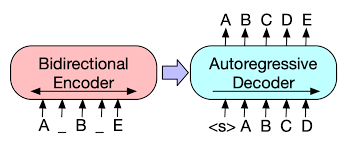

### Finally we combine the Encoder & Decoder models into a single Seq2Seq model

In [ ]:
class Seq2SeqModel(nn.Module):
    def __init__(self, embedding, hidden_size, num_words, max_target_len, device, 
                 n_layers=2, dropout=0.3, teacher_force=0.5):
        super().__init__()
        self.embedding = embedding
        self.encoder = EncoderRNN(hidden_size, self.embedding, device, 
                                  n_layers, dropout)
        self.decoder = DecoderRNN(self.embedding, hidden_size, num_words, 
                                  n_layers, dropout)
        self.teacher_force = teacher_force
        self.max_len = max_target_len
        self.device = device
    
    def forward(self, input_seq, input_lengths, target_seq):
        # input_seq: batch, seq_len 
        # target_seq: batch, seq_len 
        # input_lengths: batch

        max_target_len = target_seq.shape[1]
        batch_size = input_lengths.shape
        decoder_output_pred = []

        input_seq = input_seq.permute(1, 0) #seq_len, batch
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_lengths)

        # encoder_outputs: (seq_len, batch, hidden_size)
        # encoder_hidden: (n_layers, batch, hidden_size)

        decoder_input = target_seq.permute(1,0)[:1,:] # 1, batch
        decoder_hidden = encoder_hidden

        if random.random() < self.teacher_force:
            use_teacher_force = True
        else:
            use_teacher_force = False

        if use_teacher_force:
            # print("Using Teacher Force.\n")
            for t in range(1, max_target_len):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                # print(encoder_outputs)

                # Teacher forcing: next input is current target
                decoder_input = target_seq.permute(1,0)[t].view(1, -1).to(self.device) # 1, batch
                decoder_output_pred.append(decoder_output)

        else:
            # print("Not Using Teacher Force.\n")
            for t in range(1, max_target_len):
                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
                _, topi = decoder_output.topk(1, dim=-1)
                decoder_input = topi.squeeze(-1).detach().to(self.device) # 1, batch
                decoder_output_pred.append(decoder_output)

        decoder_output_pred = torch.cat(decoder_output_pred).to(self.device)
        # seq_len, batch, words

        return decoder_output_pred

    def predict(self, input_seq, input_lengths):

        input_seq = input_seq.permute(1, 0) #seq_len, batch
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_lengths)
        decoder_input = torch.ones(1, 1, dtype=torch.long).to(self.device)
        decoder_hidden = encoder_hidden

        all_tokens = torch.zeros([0], dtype=torch.long).to(self.device)
        all_scores = torch.zeros([0]).to(self.device)

        for t in range(1, self.max_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_hidden)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=-1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # decoder_input = decoder_input.unsqueeze(0).to(self.device)
        # Return collections of word tokens and scores
        return all_tokens, all_scores


### Important concepts:
1. Teacher forcing: It is a mechanism which helps train the network faster, by inputting the actual target value in the previous stage, as the input to the next decoding stage.
2. We implement greedy decoder for decoding. Other better and more promising decoding strategies: beam search with a fized beam width, neucleus sampling with temperature.

In [ ]:
# Below method helps us chat with the trained model.

def evaluateInput():
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = torch.tensor(tokenizer.encode(input_sentence).ids).unsqueeze(0)
            input_length = torch.tensor(input_sentence.shape[1]).unsqueeze(0)
            #1, seq_len

            # Evaluate sentence
            output_words,_ = model.predict(input_sentence.to(device), input_length.to(device))

            # Format and print response sentence
            output_words = output_words.squeeze().tolist()
            output_words = [x for x in output_words if x not in [0,1,2]]
            print('Bot:', tokenizer.decode(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [ ]:
# Training function: Performs forward propagation, backpropagation & optimization.
# We also implement gradient clipping, which prevents the gradients from exploding

def train(model, dataloader, optimizer, criterion, clip, num_words, scheduler):

    model.train()

    ep_t_loss = 0
    batch_num  = 0

    for ix, batch in enumerate(dataloader):
        batch = tuple(t.to(device) for t in batch)
        x, x_lengths, y, y_lengths = batch
        if ix % 50 == 0:
            print("Training Batch ",ix)
        
        optimizer.zero_grad()

        output = model(x, x_lengths, y)
        # print("output ",output.shape)
        # print("y ",y.shape)
        
        loss = criterion(output.view(-1, num_words),
                               y.permute(1,0)[1:].contiguous().view(-1))
        loss.backward()

        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        ep_t_loss += loss.item()
        batch_num += 1

    return ep_t_loss/batch_num

In [ ]:
# Evaluation function: Calculates loss on the validation data.

def evaluate(model, dataloader, criterion, num_words):

    model.eval()

    ep_t_loss = 0
    batch_num  = 0

    for ix, batch in enumerate(dataloader):
        batch = tuple(t.to(device) for t in batch)
        x, x_lengths, y, y_lengths = batch
        if ix % 50 == 0:
            print("Validation Batch ",ix)
        
        optimizer.zero_grad()

        with torch.no_grad():
            output = model(x, x_lengths, y)
            
            loss = criterion(output.view(-1, num_words),
                                  y.permute(1,0)[1:].contiguous().view(-1))

            ep_t_loss += loss.item()
            batch_num += 1

    return ep_t_loss/batch_num

In [ ]:
# Utility function to measure training time per epoch

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# Initializing the model with parameters
hidden_size = 512
num_words = tokenizer.get_vocab_size()
max_target_len = len(Y_tokenized[0])
n_layers = 2
dropout = 0.2
teacher_force = 0.7
clip = 5
embedding = nn.Embedding(num_words, hidden_size).to(device)

model = Seq2SeqModel(embedding, hidden_size, num_words, max_target_len, device, 
                     n_layers, dropout, teacher_force).to(device)

In [ ]:
max_target_len

25

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,303,592 trainable parameters


In [ ]:
lr = 1e-4

# We use AdamW optimizer, an improvement over the Adam optimizer
# https://towardsdatascience.com/why-adamw-matters-736223f31b5d
# Cross Entropy loss is used as the loss function
# We also experiment with a cyclic learning rate scheduler. 
# Cyclic learning rates have demonstrated capabilities of faster convergence: https://arxiv.org/pdf/1506.01186.pdf

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index=1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                              base_lr=lr,
                                              max_lr=lr*5, 
                                              cycle_momentum=False)

In [ ]:
best_valid_loss = float('inf')
tot_t_loss, tot_v_loss =[],[]

In [ ]:
N_EPOCHS = 15

In [ ]:
import time
from tqdm import tqdm
for epoch in tqdm(range(N_EPOCHS)):

# We finally start training !!

    start_time = time.time()
    
    tr_l= train(model, train_datalaoder, optimizer, criterion, 
                clip, num_words, scheduler)
    tot_t_loss.append(tr_l)

    val_l = evaluate(model, valid_datalaoder, criterion, num_words)
    tot_v_loss.append(val_l)

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if val_l < best_valid_loss:
        best_valid_loss = val_l
        torch.save(model.state_dict(), 'Chatbot_v2_least_loss.pt')
        print("\nBest Model Saved !!")
    elif epoch % 3 == 0:
        torch.save(model.state_dict(), 'Chatbot_v2_checkpoint_'+str(epoch)+'.pt')
        print("\Checkpoint Model Saved !!")
    print("\n")
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    # In information theory, perplexity is a measurement of how well a probability 
    # distribution or probability model predicts a sample. It may be used to compare 
    # probability models. A low perplexity indicates the probability distribution 
    # is good at predicting the sample.
    print(f'\tTrain Total Loss: {tr_l:.3f} | Train Perplexity: {math.exp(tr_l):.3f}')
    print(f'\tVal. Total Loss: {val_l:.3f} | Valid Perplexity: {math.exp(val_l):.3f}')
    print("_________________________________________________________________")

  0%|          | 0/15 [00:00<?, ?it/s]

Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


  7%|▋         | 1/15 [01:05<15:12, 65.21s/it]


Best Model Saved !!


Epoch: 01 | Time: 1m 4s
	Train Total Loss: 5.203 | Train Perplexity: 181.833
	Val. Total Loss: 4.687 | Valid Perplexity: 108.523
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 13%|█▎        | 2/15 [02:10<14:08, 65.29s/it]


Best Model Saved !!


Epoch: 02 | Time: 1m 5s
	Train Total Loss: 4.557 | Train Perplexity: 95.279
	Val. Total Loss: 4.520 | Valid Perplexity: 91.808
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 20%|██        | 3/15 [03:16<13:05, 65.42s/it]


Best Model Saved !!


Epoch: 03 | Time: 1m 5s
	Train Total Loss: 4.418 | Train Perplexity: 82.913
	Val. Total Loss: 4.461 | Valid Perplexity: 86.538
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 27%|██▋       | 4/15 [04:21<12:00, 65.46s/it]


Best Model Saved !!


Epoch: 04 | Time: 1m 5s
	Train Total Loss: 4.293 | Train Perplexity: 73.204
	Val. Total Loss: 4.337 | Valid Perplexity: 76.464
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 33%|███▎      | 5/15 [05:27<10:54, 65.50s/it]


Best Model Saved !!


Epoch: 05 | Time: 1m 5s
	Train Total Loss: 4.141 | Train Perplexity: 62.844
	Val. Total Loss: 4.332 | Valid Perplexity: 76.081
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 40%|████      | 6/15 [06:33<09:50, 65.59s/it]


Best Model Saved !!


Epoch: 06 | Time: 1m 5s
	Train Total Loss: 3.999 | Train Perplexity: 54.529
	Val. Total Loss: 4.109 | Valid Perplexity: 60.911
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 47%|████▋     | 7/15 [07:38<08:44, 65.55s/it]

\Checkpoint Model Saved !!


Epoch: 07 | Time: 1m 5s
	Train Total Loss: 3.876 | Train Perplexity: 48.228
	Val. Total Loss: 4.218 | Valid Perplexity: 67.893
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 53%|█████▎    | 8/15 [08:44<07:38, 65.55s/it]


Best Model Saved !!


Epoch: 08 | Time: 1m 5s
	Train Total Loss: 3.830 | Train Perplexity: 46.070
	Val. Total Loss: 4.100 | Valid Perplexity: 60.351
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 60%|██████    | 9/15 [09:49<06:33, 65.51s/it]



Epoch: 09 | Time: 1m 5s
	Train Total Loss: 3.818 | Train Perplexity: 45.498
	Val. Total Loss: 4.279 | Valid Perplexity: 72.132
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 67%|██████▋   | 10/15 [10:55<05:27, 65.59s/it]

\Checkpoint Model Saved !!


Epoch: 10 | Time: 1m 5s
	Train Total Loss: 3.750 | Train Perplexity: 42.528
	Val. Total Loss: 4.391 | Valid Perplexity: 80.745
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 73%|███████▎  | 11/15 [12:00<04:21, 65.48s/it]



Epoch: 11 | Time: 1m 5s
	Train Total Loss: 3.613 | Train Perplexity: 37.083
	Val. Total Loss: 4.278 | Valid Perplexity: 72.073
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 80%|████████  | 12/15 [13:05<03:16, 65.39s/it]



Epoch: 12 | Time: 1m 5s
	Train Total Loss: 3.335 | Train Perplexity: 28.065
	Val. Total Loss: 4.661 | Valid Perplexity: 105.716
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 87%|████████▋ | 13/15 [14:11<02:10, 65.49s/it]

\Checkpoint Model Saved !!


Epoch: 13 | Time: 1m 5s
	Train Total Loss: 3.138 | Train Perplexity: 23.047
	Val. Total Loss: 4.559 | Valid Perplexity: 95.460
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


 93%|█████████▎| 14/15 [15:17<01:05, 65.48s/it]



Epoch: 14 | Time: 1m 5s
	Train Total Loss: 2.958 | Train Perplexity: 19.268
	Val. Total Loss: 4.748 | Valid Perplexity: 115.389
_________________________________________________________________
Training Batch  0
Training Batch  50
Training Batch  100
Training Batch  150
Training Batch  200
Training Batch  250
Training Batch  300
Training Batch  350
Training Batch  400
Training Batch  450
Training Batch  500
Training Batch  550
Validation Batch  0
Validation Batch  50


100%|██████████| 15/15 [16:22<00:00, 65.48s/it]



Epoch: 15 | Time: 1m 5s
	Train Total Loss: 2.956 | Train Perplexity: 19.230
	Val. Total Loss: 4.726 | Valid Perplexity: 112.859
_________________________________________________________________


In [ ]:
model.load_state_dict(torch.load('./Chatbot_v2_checkpoint_6.pt'))

<All keys matched successfully>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp ./Chatbot_v2_checkpoint_6.pt ./drive/My\ Drive

In [ ]:
evaluateInput()

> hi
Bot: hi .
> good morning
Bot: good morning morning
> how are you doing? hope wverything is fine!
Bot: i m . . .
> what is your name?
Bot: i .
> bye
Bot: bye .
> take care
Bot: what do you want ?
> nothing
Bot: you know what you re doing .
> nope i dont
Bot: you re
> goodbye
Bot: it s all right .
> q


In [ ]:
0.001, 0.0011, 0.0012

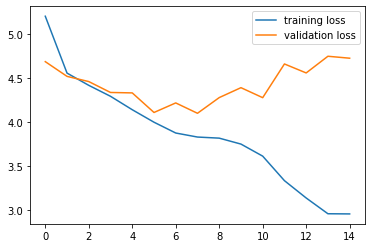

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(tot_t_loss, label='training loss')
plt.plot(tot_v_loss, label='validation loss')
plt.legend()

# Why does the model perform the way it does?

# What can be bettered?

1. Label Smoothing
2. Multi headed attention
3. Hyperparameter tuning
4. Deeper model
5. Experiment with LSTM

In [ ]:
def forward(self, src, trg, src_pos, trg_pos):
        #src, src_pos = list of turns ,[batch size, src len]
        #trg, trg_pos = [batch size, trg len]
        turns = len(src)
        batch = src[-1].shape[0]
        encoded_turns, encoder_masks = [], []
        encodings_stacked = []
        rnn_encoder_hid = torch.randn(self.rnn_layers*self.rnn_bidirectional, 
                                      batch, self.hidden_dim).to(self.device)
        rnn_enc_outputs = []

        for i in range(turns):
            src_mask = self.make_src_mask(src[i]) #[batch size, 1, 1, src len]
            turn_enc = self.encoder(src[i], src_pos[i], src_mask)
            lengths = src_mask.squeeze(1).squeeze(1).sum(-1).detach().cpu()
            # print(turn_enc.permute(1,0,2).shape, lengths.shape, rnn_encoder_hid.shape)
            # torch.Size([63, 64, 300]) torch.Size([64]) torch.Size([2, 63, 300])
            rnn_encoder_hid, rnn_encoder_op = self.rnn_encoder(turn_enc.permute(1,0,2), lengths, rnn_encoder_hid)

            rnn_enc_outputs.append(rnn_encoder_op)
            encoded_turns.append(turn_enc)
            encoder_masks.append(src_mask)
            encodings_stacked.append(torch.tanh((turn_enc * src_mask.squeeze(1).permute(0,2,1)).sum(1)))
      
        encodings_stacked_pooled = torch.stack(encodings_stacked)
        #no_turns, batch_size, dec_hidden_size

        h0 = torch.zeros(self.rnn_layers*self.rnn_bidirectional, batch, 
                         self.hidden_dim).to(self.device)

        da_op, emo_op, senti_op, conditioned_rnn_hidden = self.conditioned_rnn(encodings_stacked_pooled, h0)
        #hidden: batch, dec_hidden_size  classifier: batch, turns, n_classes

        trg_mask = self.make_trg_mask(trg)
        output_hidden = self.decoder(trg, trg_pos, encoded_turns, trg_mask, 
                                     encoder_masks) #batch size, trg len, hid dim

        if self.rnn_bidirectional == 2:
            rnn_encoder_hid = torch.sum(rnn_encoder_hid.view(-1, 2, batch, self.hidden_dim), dim=1)

        output_hidden, _ = self.out_gru(output_hidden.permute(1,0,2), rnn_encoder_hid)
        #seq_len, batch, 1 * hidden_size

        #Luong Attention
        rnn_enc_outputs = torch.cat(rnn_enc_outputs, 0) #ALL seq_len, batch, hidden_size
        attn_weights = self.attn(output_hidden, rnn_enc_outputs) #tgt or 1, batch, 1, seq_len
        context = attn_weights.matmul(rnn_enc_outputs.unsqueeze(0).repeat(attn_weights.shape[0],1,1,1).permute(0, 2, 1, 3)) # tgt or 1, batch, 1, hidden_size
        
        concat_input = torch.cat([output_hidden, context.squeeze(2)], -1) # tgt or 1, batch, hidden_size*2
        output = torch.tanh(self.concat_layer(concat_input)) # tgt or 1, batch, hidden_size

        #Final pred
        outputs = self.fc_out(output).permute(1,0,2)
        pos_outputs = self.pos_out(output).permute(1,0,2)
        
        dan_op, emon_op, sentin_op, conditioned_rnn_hidden = self.conditioned_rnn(output_hidden.mean(1).unsqueeze(0), 
                                                                                  conditioned_rnn_hidden)
        overall_emo_op = self.overall_emo_classifier(conditioned_rnn_hidden.sum(0))
        
        dan_op = dan_op.squeeze(1)
        emon_op = emon_op.squeeze(1)
        sentin_op = sentin_op.squeeze(1)
        overall_emo_op = overall_emo_op.squeeze(1)

        
        return F.log_softmax(da_op,-1), F.log_softmax(emo_op, -1), F.log_softmax(senti_op, -1), \
        F.log_softmax(dan_op, -1), F.log_softmax(emon_op, -1), F.log_softmax(sentin_op, -1), \
        F.log_softmax(overall_emo_op, -1), outputs, pos_outputs